# Parameters

In [1]:
gene_name="amacGFP"
nb_mutation_target=6
N=12 # Minimal number of predictions to select


# Imports

In [2]:
from shutil import rmtree
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.metrics import confusion_matrix,precision_score,recall_score, accuracy_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import itertools 

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from random import sample


# Constants

In [3]:
SELECTED_GFP=gene_name # do not change this
export_path = f"_07_GeneticAlgo_Results/RECAP/"
plot_range = (0,6)

In [4]:

if SELECTED_GFP=="amacGFP":
    wt_fluo = np.log10(9464.955859889827) # 3.976
elif SELECTED_GFP=="cgreGFP":
    wt_fluo = np.log10(31313.21100470826) # 4.495
elif SELECTED_GFP=="ppluGFP":
    wt_fluo = np.log10(16883.792150225145) # 4.227
else:
    wt_fluo=None

print(wt_fluo)

3.9761185929589833


# Intersection of KP and AF's validation sets

Predictions contain by definition a lot of mutations. <br>
So one genotype predicted by two models could have very different phenotypes<br>
Here, we retrieve the interesection of the validation sets used to train KP and AF's models <br>
As an indication of how both models compare to one another on a moderate number of mutations.

Import modules
Define functions
Load amacGFP data
amacGFP 239 aa


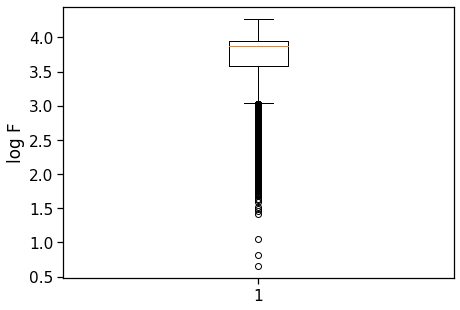

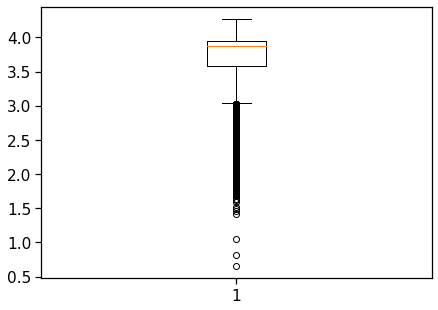

Pre-processing amacGFP
Load amacGFP encodings
Split train, valid, test sets
train_index 19803
valid_index 6601
test_index 6602


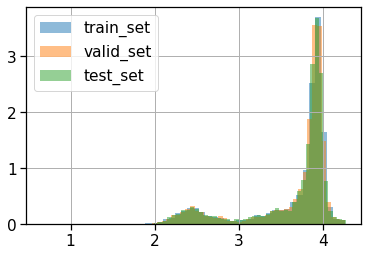

,sequences,aa_mutations_pseudo,aa_mutations_native,labels,pred
335,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,A160D:H224N,A156D:H216N,3.953688,3.888883
336,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,A160D:I203T:H236Y,A156D:I196T:H228Y,4.002990,3.923744
338,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,A160D:K245R,A156D:K237R,3.999297,4.017413
339,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,A160D:L164M:F231I,A156D:L160M:F223I,3.487692,3.383233
361,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,A160T:K169M:H238Q:M240V,A156T:K165M:H230Q:M232V,3.988069,3.926896


In [5]:
showmatrix=False
%run 01_preprocessing.ipynb

# get genotypes with mutations present at least 10 times in data
df_thresh = pd.read_csv(join(modelsPath,f"{gene_name}_df_thresh.csv"),index_col=0)

# select validation genotypes
test_genotypes_af=df.loc[[idx for idx in valid_index if idx in df_thresh.index]]

test_genotypes_af=test_genotypes_af[["full_seq","aa_genotype_pseudo","aa_genotype_native","replicates_mean_brightness"]]

# encode
#test_genotypes_af["full_seq"] = get_seq_from_genotype.fit_transform(test_genotypes_af)
predictors_tmp = one_hot_encoder(test_genotypes_af)
predictors_tmp=predictors_tmp[[col for col in predictors_tmp.columns if "*" not in col]]

# load model
model_file = join(modelsPath,f"{gene_name}_N1_N2_1_NN_optimized_filtered_training.h5")
optimised_model_filtered_training = keras.models.load_model(model_file)

# predict 
fitnesses=pd.DataFrame(np.concatenate([optimised_model_filtered_training.predict(predictors_tmp.values) for i in range(5)],axis=1),index=predictors_tmp.index)
fitnesses = fitnesses.add_prefix('Fitness_')
test_genotypes_af["pred"] = fitnesses.median(axis=1)

# rename cols
test_genotypes_af.columns=['sequences', 'aa_mutations_pseudo','aa_mutations_native','labels', 'pred']

test_genotypes_af.head()

amacGFP


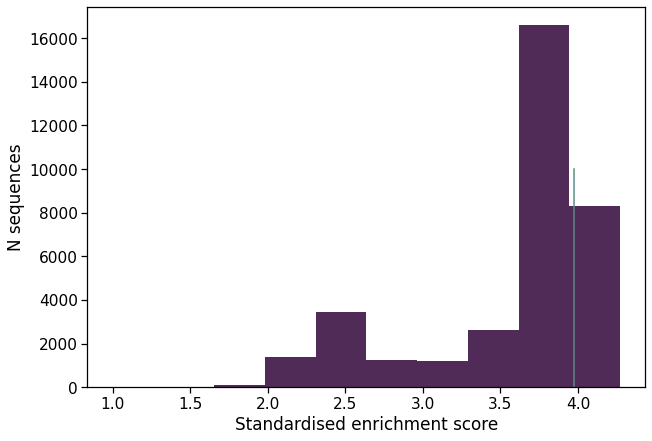

Number of sequences = 34949


,sequences,aa_mutations_pseudo,aa_mutations_native,labels,pred
11262,MSKGEELFTGIVPVLVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,I18V:I198F:M240I,I15V:I194F:M232I,3.964798,3.757673
4822,MSKGDELFTGIVPVLIELGGDVHGHKFSVRGEGEGDADYGKLEIKF...,E7D:D21G:M156I,E4D:D18G:M152I,4.008252,3.817106
3000,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,E135G,E131G,3.966747,3.828399
14702,MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGRLEIKF...,K43R:F227I,K40R:F219I,4.004342,3.843727
10898,MSKGEELFTGTLPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,I13T:V14L:K108R,I10T:V11L:K104R,3.905593,3.804481


In [6]:
%run kp03_load_data_ml.ipynb

# split train/test as in kp04_ffnn.ipynb
(x_train, x_test, 
y_train, y_test, 
idx_train, idx_test) = train_test_split(genotype_matrix, 
                                        labels, range(len(labels)),
                                        test_size=0.1,random_state=42)

# select validation genotypes
test_genotypes_kp=df.loc[idx_test]
test_genotypes_kp=test_genotypes_kp[~test_genotypes_kp.aa_mutations_pseudo.str.contains('\*')] # removing stop codons

#encode
enc =load(f'4_ML/1_encoders/2D_encoder_{SELECTED_GFP}.joblib')
genotype_matrix = enc.transform([list(sq) for sq in list(test_genotypes_kp.sequences)]).toarray()

# load model
model = keras.models.load_model(f'4_ML/2_models/{SELECTED_GFP}_DNN.h5')

#predict validation genotypes
test_set_predictions_kp = model.predict([genotype_matrix]).flatten()
test_genotypes_kp["pred"]=test_set_predictions_kp

# add native genotypes
test_genotypes_kp["aa_mutations_native"]=test_genotypes_kp.aa_mutations_pseudo.apply(lambda x:pseudo_genotype_to_native(x))
test_genotypes_kp=test_genotypes_kp[['sequences', 'aa_mutations_pseudo','aa_mutations_native','labels', 'pred']]

test_genotypes_kp.head()

In [7]:
# get intersection with sequences, genotypes, labels, and KP/AF predicted fluorescences, prediction error
test_genotypes_intersection = test_genotypes_kp[test_genotypes_kp.aa_mutations_native.isin(test_genotypes_af.aa_mutations_native.to_list())]
test_genotypes_intersection = test_genotypes_intersection.rename(columns={"pred":"pred_KP"})
test_genotypes_intersection=test_genotypes_intersection.sort_values(by=["aa_mutations_pseudo"])


test_genotypes_intersection["pred_AF"]=test_genotypes_af[test_genotypes_af.aa_mutations_native.isin(test_genotypes_kp.aa_mutations_native.to_list())].sort_values(by=["aa_mutations_pseudo"]).pred.values
test_genotypes_intersection["nb_muts"]=test_genotypes_intersection.aa_mutations_native.apply(lambda x:len(x.split(":")))

test_genotypes_intersection["KP_error"]= test_genotypes_intersection.pred_KP-test_genotypes_intersection.labels
test_genotypes_intersection["AF_error"]= test_genotypes_intersection.pred_AF-test_genotypes_intersection.labels


if gene_name=="amacGFP":functionality_threshold=3
elif gene_name=="cgreGFP":functionality_threshold=3.5
elif gene_name=="ppluGFP":functionality_threshold=3.5
# based on measured fluorescence, annotate genotypes as functional or dead
test_genotypes_intersection["functionality"]=test_genotypes_intersection.labels.apply(lambda x:int(x>functionality_threshold))

print(f"Intersection contains {len(test_genotypes_intersection)} genotypes")

Intersection contains 620 genotypes


# Get genetic algo results

In [8]:
# genetic algo output

try:
    GA_predictions =pd.read_csv(join(geneticAlgo_output_folder,f"RECAP/Recap_{SELECTED_GFP}_target{nb_mutation_target}muts.csv"))
except:
    print(f"File not found.")
    print(f"Did you do run(s) of genetic algorithm for {gene_name} with {nb_mutation_target} mutations?")
    print(f"Did you generate the recap file?")
    
cols = ["full_seq","aa_genotype_native","Fitness","Std","Fitness_with_plate1","Std_with_plate1","times_predicted_in_generation","times_trained","measured","in_train_set","aa_genotype_pseudo","run"]
cols = [col for col in cols if col in GA_predictions.columns]
GA_predictions=GA_predictions[cols]
GA_predictions = GA_predictions.sort_values(by='Fitness', ascending=False) # Fitness : prediction by AF's model


## Basic recap

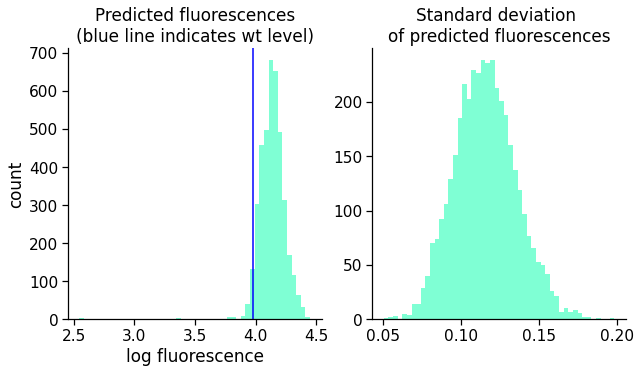

Total of 4000 genotypes.


In [9]:

# basic plots
plt.figure(figsize=[10, 5])

plt.subplot(1,2,1)
plt.hist(GA_predictions.Fitness,bins=50,color="aquamarine")
sns.despine()
plt.title('Predicted fluorescences\n(blue line indicates wt level)')
plt.xlabel("log fluorescence")
plt.ylabel("count")
plt.axvline(wt_fluo,c="b")

plt.subplot(1,2,2)
plt.hist(GA_predictions.Std,bins=50,color="aquamarine")
sns.despine()
plt.title('Standard deviation \nof predicted fluorescences')

plt.show()

print(f"Total of {len(GA_predictions)} genotypes.")

## Saturation curves

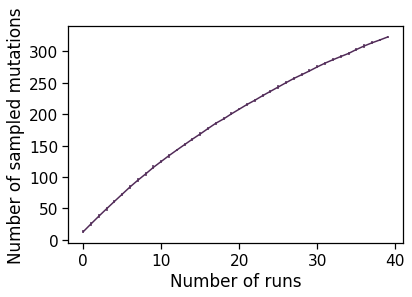

In [10]:
# To see how many mutations have been sampled in the GA predictions

all_curves = []
for i in range(50):
    one_curve = []
    muts_seen=[]
    for run in sample(list(GA_predictions.run.unique()),len(GA_predictions.run.unique())) :
        new_muts=0
        # get mutations
        sub = GA_predictions[GA_predictions.run==run]
        muts = sorted(list(set(flatten([elt.split(":") for elt in sub.aa_genotype_pseudo.values]))))
        for mut in muts:
            if mut not in muts_seen:
                new_muts+=1
                muts_seen.append(mut)
        one_curve.append(new_muts)
    all_curves.append(one_curve)

# plot cumulative number of mutations as we add more runs
all_curves_as_df = pd.DataFrame(all_curves)

m = all_curves_as_df.mean()
cumulative = [sum(m[:i+1]) for i in range(len(m))]


plt.rc('figure', facecolor='w')
x = range(len(all_curves_as_df.mean()))
y = cumulative
yerr = all_curves_as_df.std()
plt.errorbar(x, y, yerr=yerr)
plt.xlabel("Number of runs")
plt.ylabel("Number of sampled mutations")

plt.show()

## GA results as predicted by KP's model

In [11]:
# predict GA-predicted genotypes with KP's model
enc =load(f'4_ML/1_encoders/2D_encoder_{SELECTED_GFP}.joblib')
genotype_matrix = enc.transform([list(sq) for sq in list(GA_predictions.full_seq)]).toarray()

# load model
model = keras.models.load_model(f'4_ML/2_models/{SELECTED_GFP}_DNN.h5')

#predict validation genotypes
GA_predictions_kp = model.predict([genotype_matrix]).flatten()
GA_predictions["Fitness_kp"]=GA_predictions_kp


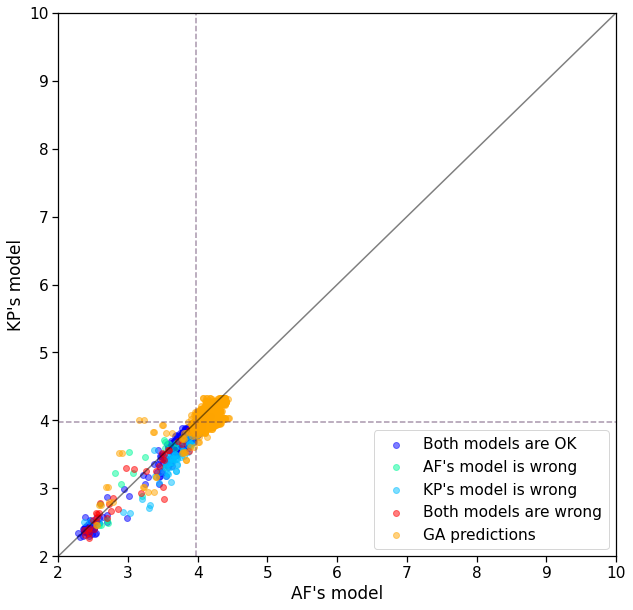

Spearman AF/KP models on test set 0.8745280546448334, 
pval 2.1817311686411667e-196

Spearman AF/KP models on GA predictions 0.6369402486830184, 
pval 0.0


In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('w')


# diag
plot_lims=(2,10)
plt.plot(plot_lims,plot_lims,"k",alpha=0.5)
plt.xlim(plot_lims)
plt.ylim(plot_lims)

# wt fluo
plt.axvline(wt_fluo,ls="--",alpha=0.5)
plt.axhline(wt_fluo,ls="--",alpha=0.5)


# plot test genotypes when...
error_threshold=0.25

# both models are OK
subset = test_genotypes_intersection[(test_genotypes_intersection.KP_error.abs()<error_threshold)&\
                                     (test_genotypes_intersection.AF_error.abs()<error_threshold)]

plt.scatter(x=subset.pred_AF,y=subset.pred_KP,marker='o', color="b",alpha=0.5,label="Both models are OK")

# AF's model is wrong
subset = test_genotypes_intersection[(test_genotypes_intersection.KP_error.abs()< error_threshold)&\
                                     (test_genotypes_intersection.AF_error.abs()>=error_threshold)]

plt.scatter(x=subset.pred_AF,y=subset.pred_KP,marker='o', color="mediumspringgreen",alpha=0.5,label="AF's model is wrong")


# KP's model is wrong
subset = test_genotypes_intersection[(test_genotypes_intersection.KP_error.abs()>=error_threshold)&\
                                     (test_genotypes_intersection.AF_error.abs()< error_threshold)]

plt.scatter(x=subset.pred_AF,y=subset.pred_KP,marker='o', color="deepskyblue",alpha=0.5,label="KP's model is wrong")
    

# both models are wrong
subset = test_genotypes_intersection[(test_genotypes_intersection.KP_error.abs()>=error_threshold)&\
                                     (test_genotypes_intersection.AF_error.abs()>=error_threshold)]

plt.scatter(x=subset.pred_AF,y=subset.pred_KP,marker='o', color="r",alpha=0.5,label="Both models are wrong")


# plot GA predictions
plt.scatter(x=GA_predictions.Fitness,y=GA_predictions.Fitness_kp,marker='o', color="orange",alpha=0.5,label="GA predictions")

plt.xlabel("AF's model")
plt.ylabel("KP's model")

plt.legend()
plt.plot()

plt.show()

sr=spearmanr(test_genotypes_intersection.pred_KP,test_genotypes_intersection.pred_AF)
print(f"Spearman AF/KP models on test set {sr.correlation}, \npval {sr.pvalue}\n")

sr=spearmanr(GA_predictions.Fitness_kp,GA_predictions.Fitness)
print(f"Spearman AF/KP models on GA predictions {sr.correlation}, \npval {sr.pvalue}")


# Select predictions

## Unique genotypes

In [13]:
GA_predictions = GA_predictions.groupby("aa_genotype_native", group_keys=False).apply(lambda df: df.sample(1))
print(f"Total of {len(GA_predictions)} unique genotypes.")

Total of 767 unique genotypes.


## Genotypes with nb_mutation_target

In [14]:
GA_predictions["nb_muts"] = GA_predictions["aa_genotype_native"].apply(lambda x: len(x.split(":")))
GA_predictions = GA_predictions[GA_predictions["nb_muts"]==nb_mutation_target]
print(f"Total of {len(GA_predictions)} genotypes with {nb_mutation_target} mutations.")

Total of 204 genotypes with 6 mutations.


## Brighter than WT according to both KP and AF's models

In [15]:
# select genotypes that are brighter than WT according to both models 
# increase tolerance manually when predicting genotypes with many mutations
# to decrease minimum requested fluorescence

tolerance=0 

GA_predictions = GA_predictions[(GA_predictions.Fitness   >wt_fluo-tolerance) &\
                                (GA_predictions.Fitness_kp>wt_fluo-tolerance)]

GA_predictions.to_csv(join(export_path,f"Recap_{SELECTED_GFP}_target{nb_mutation_target}_table1.csv"))

print(f"Total of {len(GA_predictions)} genotypes brighter than wt.")

Total of 151 genotypes brighter than wt.


## Impact of sampled mutations

### List deleterious, beneficial, neutral and uncertain (not enough contexts) mutations


In [16]:

# all_mutations_in_all_backgrounds_dict_with_avGFP_Aubin_native : native mutations
# all_mutations_in_all_backgrounds_dict_with_avGFP_Aubin : pseudo positions, we use this one here

infile=join(cachedDataPath,f"all_mutations_in_all_backgrounds_dict_with_avGFP.pkl")
mutations_in_all_backgrounds = pickle.load(open(infile, "rb" ))
mutations=mutations_in_all_backgrounds[gene_name]

deleterious_muts, neutral_muts, beneficial_muts, uncertain_muts=[],[],[],[]

for mutation, in_all_backgrounds in mutations.items():
    
    fitness_impacts = in_all_backgrounds['with_mut'] - in_all_backgrounds['background']

    if len(fitness_impacts)>=5:
        fitness_impact=fitness_impacts.median()
        
        if fitness_impact>0.1:
            beneficial_muts.append(mutation)
        elif fitness_impact<-0.1:
            deleterious_muts.append(mutation)
        else:
            neutral_muts.append(mutation)
    else:
        uncertain_muts.append(mutation)


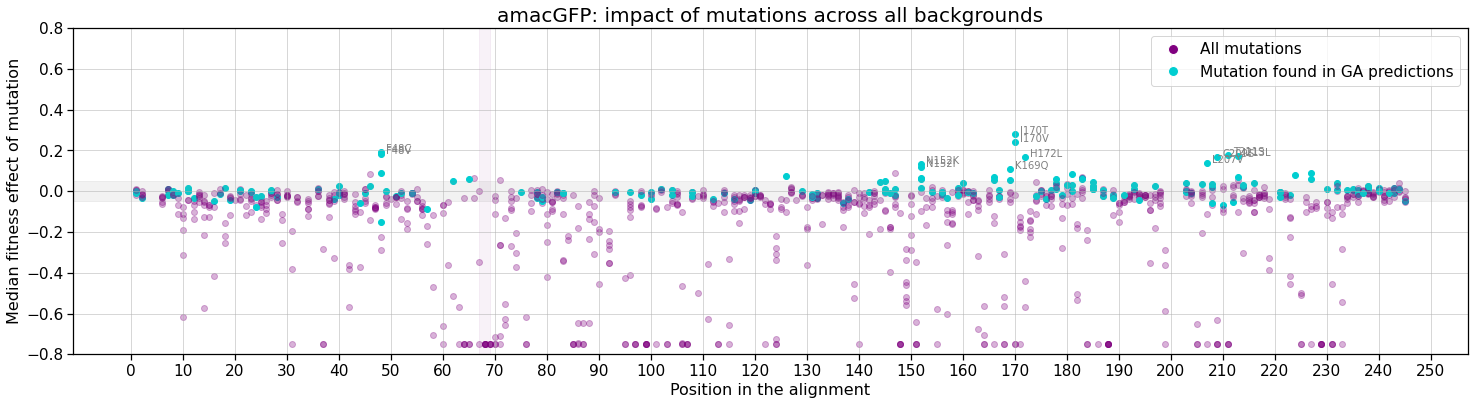

In [17]:
verbose=False


# get mutations found in predictions
GA_predictions_muts = sorted(list(set(itertools.chain.from_iterable([elt.split(":") for elt in GA_predictions["aa_genotype_pseudo"].values.flatten()]))))

fig, ax = plt.subplots(figsize=(25,6))
fig.patch.set_facecolor('w')

for mutation, in_all_backgrounds in mutations.items():
    
    if mutation!="wt":
        
        position = int(mutation[1:-1])
        
        if len(in_all_backgrounds) >=4:
            
            fitness_impacts = in_all_backgrounds['with_mut'] - in_all_backgrounds['background']

            fitness_impact = max(-0.75, fitness_impacts.median())
            fitness_impact = min(0.75, fitness_impact)

            if mutation in GA_predictions_muts:
                plt.scatter(position, fitness_impact, c='darkturquoise')
            else:
                plt.scatter(position, fitness_impact, c='purple', alpha=0.3)
            if fitness_impact > 0.1:
                plt.text(position+1, fitness_impact, mutation, ha='left', color='grey', fontsize=10)
            
plt.xticks(np.arange(0,251,10), [str(i) for i in np.arange(0,251,10)])
ax.axvspan(67, 69, color='purple', alpha=0.05)
ax.axhspan(-0.05, 0.05, color='grey', alpha=0.1)
plt.grid(alpha=0.5)
plt.ylim(-0.8, 0.8)


title = '%s: impact of mutations across all backgrounds' %(gene_name)
plt.title(title, fontsize=20)
plt.xlabel('Position in the alignment', fontsize=16)
plt.ylabel('Median fitness effect of mutation', fontsize=16)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='All mutations',
                          markerfacecolor='purple', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Mutation found in GA predictions',
                          markerfacecolor='darkturquoise', markersize=10)]

ax.legend(handles=legend_elements, loc='upper right')

plt.show()


mutations not seen in enough contexts are not plotted. <br>
Note : unlike in the genetic algorithm (threshold of 10), the threshold here is 5 

### Remove genotypes with severely deleterious mutations


In [18]:

idx_keep=[]
for ID,row in GA_predictions.iterrows():
    genotype_pseudo=row.aa_genotype_pseudo
    discard=False
    for mut in genotype_pseudo.split(":"):
        if mut in deleterious_muts:
            discard=True
    if not discard:idx_keep.append(ID)

GA_predictions=GA_predictions.loc[idx_keep]
print(f"Total of {len(GA_predictions)} genotypes after removing severely deleterious mutations.")

GA_predictions.to_csv(join(export_path,f"Recap_{SELECTED_GFP}_target{nb_mutation_target}_table2.csv"))

Total of 150 genotypes after removing severely deleterious mutations.


### Remove genotypes with uncertain mutations


In [19]:

idx_keep=[]
for ID,row in GA_predictions.iterrows():
    genotype_pseudo=row.aa_genotype_pseudo
    discard=False
    for mut in genotype_pseudo.split(":"):
        if mut in uncertain_muts:
            discard=True
    if not discard:idx_keep.append(ID)

GA_predictions=GA_predictions.loc[idx_keep]
print(f"Total of {len(GA_predictions)} genotypes after removing uncertain mutations.")

GA_predictions.to_csv(join(export_path,f"Recap_{SELECTED_GFP}_target{nb_mutation_target}_table3.csv"))


Total of 117 genotypes after removing uncertain mutations.


In [20]:
# out of curiosity, number of genotypes with on ly beneficial mutations?

idx_keep = []
for ID,row in GA_predictions.iterrows():
    genotype_pseudo= row.aa_genotype_pseudo
    benef_only = True
    for mut in genotype_pseudo.split(":"):
        if mut not in beneficial_muts:benef_only=False
    if benef_only:idx_keep.append(ID)


print(f"{len(idx_keep)} genotypes contain only beneficial mutations")

0 genotypes contain only beneficial mutations


## Number of extant/non-extant mutations (no filter)

We do not actually select/filter the predictions to contain more non-extant mutations <br>
Instead, we tried enriching the predictions in non-extant mutations <br>
by changing the parameters of the genetic algorithm.

In [21]:
# these objects use native numbering

with open(join(cachedDataPath,"extant_muts_all_genes.pkl"),"rb") as infile:
    extant_muts=pickle.load(infile)
    extant_muts=extant_muts[gene_name]

with open(join(cachedDataPath,"nonextant_muts_all_genes.pkl"),"rb") as infile:
    non_extant_muts=pickle.load(infile)
    non_extant_muts=non_extant_muts[gene_name]

In [22]:
GA_predictions["nb_non_extant_muts"]=GA_predictions.aa_genotype_native.apply(lambda x: sum([mut in non_extant_muts for mut in x.split(":")]))
GA_predictions["nb_extant_muts"]=GA_predictions.nb_muts-GA_predictions.nb_non_extant_muts #for convenience

In [23]:
GA_predictions=GA_predictions.sort_values(by=["nb_non_extant_muts"])

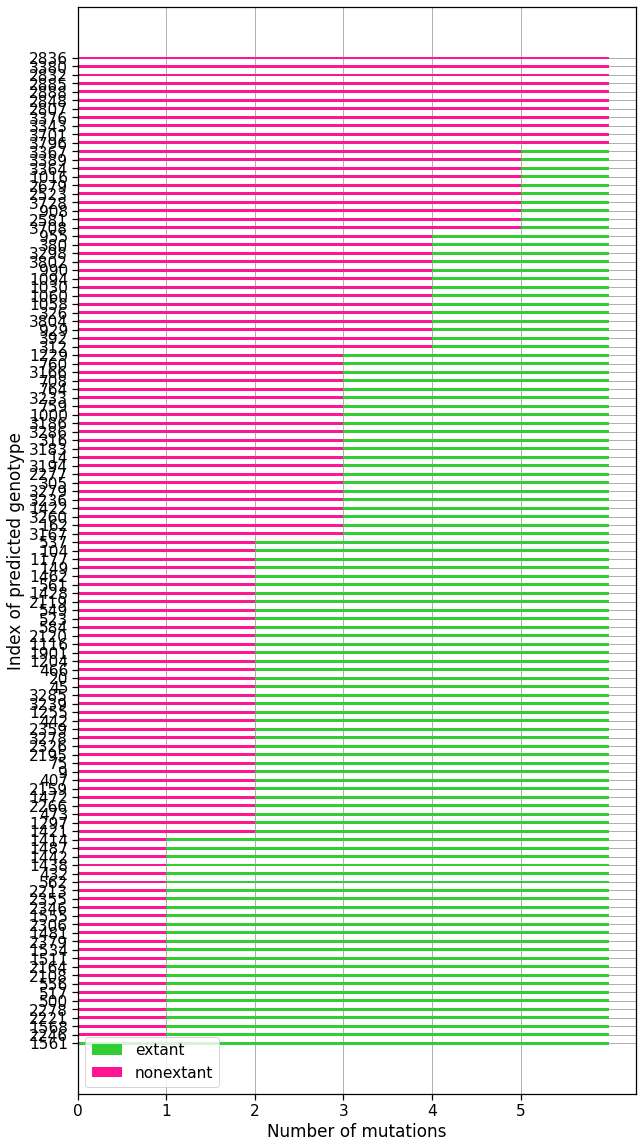

In [24]:
width = 0.35 # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(10, 20))
fig.patch.set_facecolor('w')

p1 = plt.barh(range(len(GA_predictions)), [sum(elt) for elt in zip(GA_predictions.nb_extant_muts,GA_predictions.nb_non_extant_muts)], width,color="limegreen") # extant databar in the background
p2 = plt.barh(range(len(GA_predictions)), GA_predictions.nb_non_extant_muts, width,color="deeppink") # nonextant databar on the front

plt.xlabel('Number of mutations')
plt.xticks(range(nb_mutation_target))
plt.yticks(range(len(GA_predictions)),labels=GA_predictions.index)
plt.ylabel("Index of predicted genotype")
plt.legend((p1[0], p2[0]), ('extant', 'nonextant'))
plt.grid()
ax.set_axisbelow(True)

plt.show()


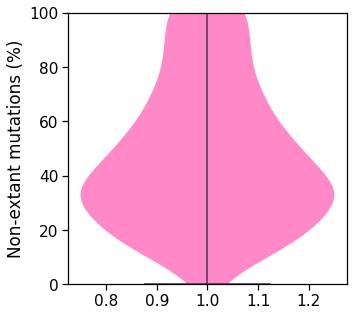

In [25]:
# % of non extant mutations as a distribution

ratio = [100*GA_predictions.nb_non_extant_muts/(GA_predictions.nb_extant_muts+GA_predictions.nb_non_extant_muts)]
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('w')
bp = ax.violinplot(ratio)
for pc in bp["bodies"]:
    pc.set_facecolor("deeppink")
    pc.set_alpha(0.5)
    
plt.ylabel("Non-extant mutations (%)")
plt.ylim(0,100)

plt.show()


## Most diverse sequences (filter)


using cd-hit to generate clusters <br>
http://medcraveonline.com/MOJPB/MOJPB-05-00174.pdf <br>
http://www.bioinformatics.org/cd-hit/cd-hit-user-guide.pdf <br>

### cd-hit

In [26]:
# save all predictions as fasta (no need to align, they are aligned by definition)
with open(join(geneticAlgo_output_folder,f"RECAP/{SELECTED_GFP}_ALL_PREDICTIONS_{nb_mutation_target}muts.fasta"),"w") as out:
    for ID,row in GA_predictions.iterrows():
        out.write(f">{ID}\n") # identify sequences by their index
        out.write(f"{str(row['full_seq']).replace('*','')}\n")

# Loop : call cd-hit with increasing minimum similarity threshold
# until we have enough separate clusters
# According to user guide, the "n" parameter should be set as follows:
# -n 5 for thresholds 0.7 ~ 1.0 
# -n 4 for thresholds 0.6 ~ 0.7 
# -n 3 for thresholds 0.5 ~ 0.6 
# -n 2 for thresholds 0.4 ~ 0.5

nb_clusters = 0
simi_thresh=0.5
simi_step=0.01
while nb_clusters<N and simi_thresh<=1:
    simi_thresh+=simi_step
    if simi_thresh>=0.4 and simi_thresh<0.5:n=2
    elif simi_thresh>=0.5 and simi_thresh<0.6:n=3
    elif simi_thresh>0.6 and simi_thresh<0.7:n=4
    elif simi_thresh>0.7 and simi_thresh<1:n=5
    else:pass
    i = join(geneticAlgo_output_folder,f"RECAP/{SELECTED_GFP}_ALL_PREDICTIONS_{nb_mutation_target}muts.fasta")
    !cd-hit -i $i -o clusters -c $simi_thresh -n $n

    # quickly check number of clusters
    with open("clusters") as fasta_file:
        nb_clusters=fasta_file.read().count(">")

                  
# keep only representative sequences
with open("clusters","r") as f:
    representative_indexes = [int(l[1:-1]) for l in f.readlines() if ">" in l]

GA_predictions_subset = GA_predictions.loc[representative_indexes,:]
GA_predictions_subset = GA_predictions_subset.sort_index()


for f in ["clusters","clusters.clstr"]:
    try:
        os.remove(f)
    except:
        pass


Program: CD-HIT, V4.8.1 (+OpenMP), Jan 12 2021, 16:51:10
Command: cd-hit -i
         _07_GeneticAlgo_Results/RECAP/amacGFP_ALL_PREDICTIONS_6muts.fasta
         -o clusters -c 0.51 -n 3

Started: Thu Jun 17 17:29:30 2021
                            Output                              
----------------------------------------------------------------
total seq: 117
longest and shortest : 238 and 238
Total letters: 27846
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 0M = 0M
Miscellaneous   : 0M
Total           : 10M

Table limit with the given memory limit:
Max number of representatives: 2333461
Max number of word counting entries: 98658166

comparing sequences from          0  to        117

      117  finished          1  clusters

Approximated maximum memory consumption: 10M
writing new database
writing clustering information
program completed !

Total CPU time 0.01
Program: CD-HIT, V4.8.1 

Program: CD-HIT, V4.8.1 (+OpenMP), Jan 12 2021, 16:51:10
Command: cd-hit -i
         _07_GeneticAlgo_Results/RECAP/amacGFP_ALL_PREDICTIONS_6muts.fasta
         -o clusters -c 0.5900000000000001 -n 3

Started: Thu Jun 17 17:29:32 2021
                            Output                              
----------------------------------------------------------------
total seq: 117
longest and shortest : 238 and 238
Total letters: 27846
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 0M = 0M
Miscellaneous   : 0M
Total           : 10M

Table limit with the given memory limit:
Max number of representatives: 2333461
Max number of word counting entries: 98658166

comparing sequences from          0  to        117

      117  finished          1  clusters

Approximated maximum memory consumption: 10M
writing new database
writing clustering information
program completed !

Total CPU time 0.01
Program: C

Program: CD-HIT, V4.8.1 (+OpenMP), Jan 12 2021, 16:51:10
Command: cd-hit -i
         _07_GeneticAlgo_Results/RECAP/amacGFP_ALL_PREDICTIONS_6muts.fasta
         -o clusters -c 0.6700000000000002 -n 4

Started: Thu Jun 17 17:29:33 2021
                            Output                              
----------------------------------------------------------------
total seq: 117
longest and shortest : 238 and 238
Total letters: 27846
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 3M = 3M
Miscellaneous   : 0M
Total           : 13M

Table limit with the given memory limit:
Max number of representatives: 2324699
Max number of word counting entries: 98287726

comparing sequences from          0  to        117

      117  finished          1  clusters

Approximated maximum memory consumption: 13M
writing new database
writing clustering information
program completed !

Total CPU time 0.01
Program: C

writing new database
writing clustering information
program completed !

Total CPU time 0.06
Program: CD-HIT, V4.8.1 (+OpenMP), Jan 12 2021, 16:51:10
Command: cd-hit -i
         _07_GeneticAlgo_Results/RECAP/amacGFP_ALL_PREDICTIONS_6muts.fasta
         -o clusters -c 0.7500000000000002 -n 5

Started: Thu Jun 17 17:29:35 2021
                            Output                              
----------------------------------------------------------------
total seq: 117
longest and shortest : 238 and 238
Total letters: 27846
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 75M

Table limit with the given memory limit:
Max number of representatives: 2140705
Max number of word counting entries: 90508486

comparing sequences from          0  to        117

      117  finished          1  clusters

Approximated maximum memory consumption: 75M
writing 

writing new database
writing clustering information
program completed !

Total CPU time 0.06
Program: CD-HIT, V4.8.1 (+OpenMP), Jan 12 2021, 16:51:10
Command: cd-hit -i
         _07_GeneticAlgo_Results/RECAP/amacGFP_ALL_PREDICTIONS_6muts.fasta
         -o clusters -c 0.8300000000000003 -n 5

Started: Thu Jun 17 17:29:37 2021
                            Output                              
----------------------------------------------------------------
total seq: 117
longest and shortest : 238 and 238
Total letters: 27846
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 75M

Table limit with the given memory limit:
Max number of representatives: 2140705
Max number of word counting entries: 90508486

comparing sequences from          0  to        117

      117  finished          1  clusters

Approximated maximum memory consumption: 75M
writing 

writing new database
writing clustering information
program completed !

Total CPU time 0.06
Program: CD-HIT, V4.8.1 (+OpenMP), Jan 12 2021, 16:51:10
Command: cd-hit -i
         _07_GeneticAlgo_Results/RECAP/amacGFP_ALL_PREDICTIONS_6muts.fasta
         -o clusters -c 0.9100000000000004 -n 5

Started: Thu Jun 17 17:29:39 2021
                            Output                              
----------------------------------------------------------------
total seq: 117
longest and shortest : 238 and 238
Total letters: 27846
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 75M

Table limit with the given memory limit:
Max number of representatives: 2140705
Max number of word counting entries: 90508486

comparing sequences from          0  to        117

      117  finished          1  clusters

Approximated maximum memory consumption: 75M
writing 

### plotting representative sequences

In [27]:
def hamming_distance(string1, string2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(string1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if string1[i] != string2[i]:
            distance += 1
    # Return the final count of differences
    return distance

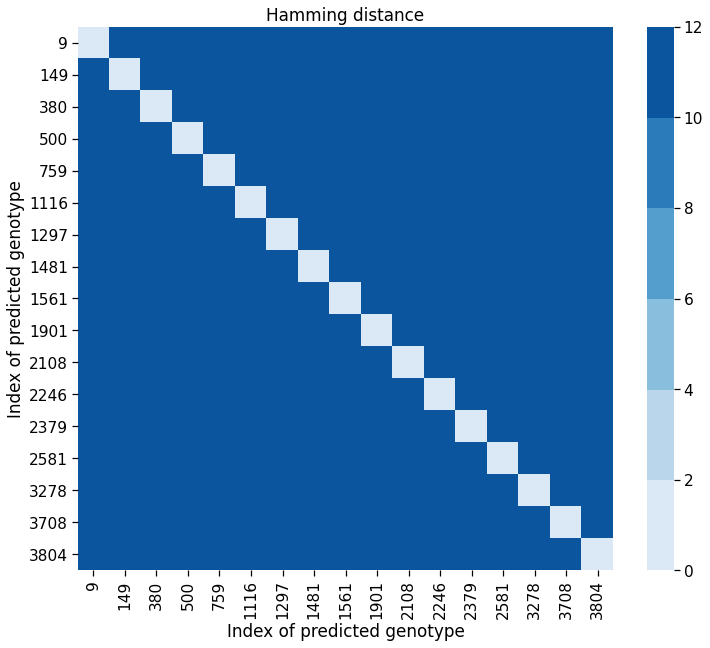

In [28]:
# plot hamming distance between selected sequences
distance_table_subset = [[hamming_distance(seq1,seq2) for seq2 in GA_predictions_subset["full_seq"].values] for seq1 in GA_predictions_subset["full_seq"].values]
distance_table_subset = pd.DataFrame(distance_table_subset,index=GA_predictions_subset.index,columns=GA_predictions_subset.index)

fig, ax = plt.subplots(figsize=(12,10))
fig.patch.set_facecolor('w')
ax = sns.heatmap(distance_table_subset,cmap=sns.color_palette("Blues"))#linewidth=0.5
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
plt.title("Hamming distance")
plt.ylabel("Index of predicted genotype")
plt.xlabel("Index of predicted genotype")

plt.show()

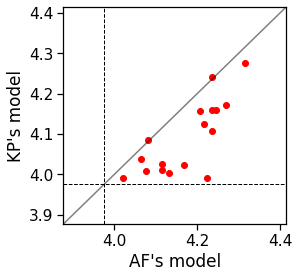

In [29]:
# plot fitness distribution of the predictions
fig, ax = plt.subplots(figsize=(4,4))
fig.patch.set_facecolor('w')


plt.axvline(wt_fluo, color='k', linestyle='dashed', linewidth=1)
plt.axhline(wt_fluo, color='k', linestyle='dashed', linewidth=1)
plt.xlabel("AF's model")
plt.ylabel("KP's model")

lims=wt_fluo-0.1,max(max(GA_predictions_subset.Fitness),max(GA_predictions_subset.Fitness_kp))+0.1
plt.xlim(lims)
plt.ylim(lims)

plt.scatter(GA_predictions_subset.Fitness,GA_predictions_subset.Fitness_kp,color="red")


plt.plot(lims,lims,"k",alpha=0.5)
plt.show()

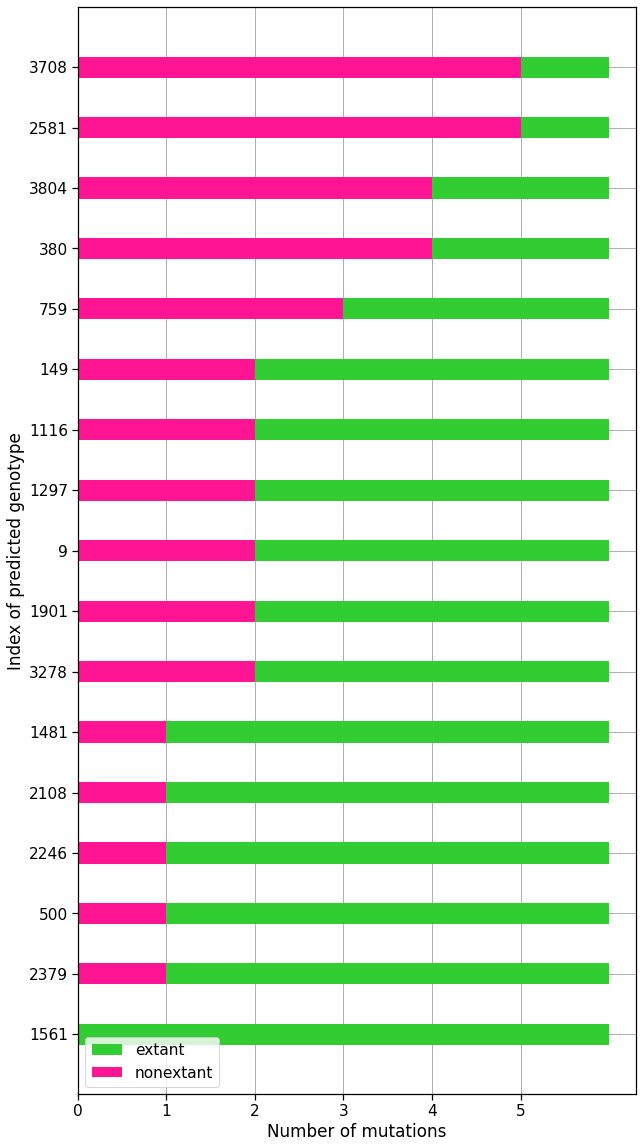

In [30]:

GA_predictions_subset=GA_predictions_subset.sort_values(by=["nb_non_extant_muts"])

width = 0.35 # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(10, 20))
fig.patch.set_facecolor('w')

p1 = plt.barh(range(len(GA_predictions_subset)), [sum(elt) for elt in zip(GA_predictions_subset.nb_extant_muts,GA_predictions_subset.nb_non_extant_muts)], width,color="limegreen") # extant databar in the background
p2 = plt.barh(range(len(GA_predictions_subset)), GA_predictions_subset.nb_non_extant_muts, width,color="deeppink") # nonextant databar on the front

plt.xlabel('Number of mutations')
plt.xticks(range(nb_mutation_target))
plt.yticks(range(len(GA_predictions_subset)),labels=GA_predictions_subset.index)
plt.ylabel("Index of predicted genotype")
plt.legend((p1[0], p2[0]), ('extant', 'nonextant'))
plt.grid()
ax.set_axisbelow(True)

plt.show()


# Export selected predictions

In [31]:
# Finally, export sequences for testing in the lab
table4_file_path = join(export_path,f"Recap_{SELECTED_GFP}_target{nb_mutation_target}_table4.csv")
print(table4_file_path)

GA_predictions_subset.to_csv(table4_file_path)


_07_GeneticAlgo_Results/RECAP/Recap_amacGFP_target6_table4.csv
